In [28]:
import numpy as np
import matplotlib.pyplot as plt
import random
import sklearn.datasets as skdata
import scipy.optimize as optimize
import math
import scipy.stats as sts
import time
from rvm_class import RVM_reg
from svm_reg_class import SVM_reg
from collections import deque
from numpy import linalg
from data_gen import genData
dirData = 'Data/'

# Hyperparameter tuning functions

In [29]:
def createFolds(X, N = 5):
    """ Seperates data in N folds preparing the data for N-fold CV.
    
    Args:
        X: matrix with input data
        N: number of folds
        
    Returns:
        A list with N tuples. Each tuple has a list of indices for the training data
        and a list of indices for the validation data..
    """
    input_size = X.shape[0]
    indices = [i for i in range(input_size)]
    chunk_size = int(input_size / N)

    fold_list = []
    for i in range(N):
        training_indices = []
        for i in range(0, input_size - chunk_size, chunk_size):
            training_indices.extend(indices[i:i + chunk_size])
        validation_indices = indices[input_size - chunk_size: input_size]
        fold_list.append((training_indices, validation_indices))
        # Put validation data in the front so that it is training data on the next fold
        indices = validation_indices + training_indices
    return fold_list

In [30]:
def tune_hyperparams(X, Y, params, model_type, N = 5, rvmType = "EM", svmType = 'C', kerType = "radial"):
    """ Hyperparameter tuning using a grid search and N-fold CV.
    
    Args:
        X: matrix with input data
        Y: vector with output data
        params: list of lists with the possible values for each parameter
        model_type: name of the model to be used
        N: number of folds
        rvmType: type of rvm (EM,DD,SSBL) in case model_type is "rvm"
        svmType: type of svm (C or V)
        kerType: type of kernel
        
    Returns:
        A tuple with the parameters that achieved the best performance.
        
    """
    
    fold_indices = createFolds(X, N)
    min_error = 1e+50
    if model_type == "svm_reg":
        C_idx, eps_idx, sigma_idx = (-1, -1, -1)
        # For each combination of parameters
        for idx1, C in enumerate(params[0]):
            for idx2, epsilon in enumerate(params[1]):
                for idx3, sigma in enumerate(params[2]):
                    # Do N-fold CV
                    error = 0
                    try:
                        for i in range(N):
                            train_indices, val_indices = fold_indices[i]
                            X_tr = X[train_indices]
                            Y_tr = Y[train_indices]
                            X_val = X[val_indices]
                            Y_val = Y[val_indices]
                            svm = SVM_reg(svmType = svmType, kerType = kerType, C = C, eps = epsilon,  sigma = sigma)
                            svm.train(X_tr, Y_tr)
                            Y_pred = svm.pred(X_val)
                            error += np.sum(np.abs(Y_pred - Y_val) ** 2) / Y_val.shape[0]
                    except Exception as e:
                        print(e)
                        continue

                    if error / N < min_error:
                        C_idx = idx1
                        eps_idx = idx2
                        sigma_idx = idx3
                        min_error = error / N
                
        return (C_idx, eps_idx, sigma_idx)
    elif model_type == "rvm_reg":
        sigma_idx = -1
        # For each gaussian kernel sigma
        for idx1, sigma in enumerate(params[0]):
            # Do N-fold CV
            error = 0
            try:
                for i in range(N):
                    train_indices, val_indices = fold_indices[i]
                    X_tr = X[train_indices]
                    Y_tr = Y[train_indices]
                    X_val = X[val_indices]
                    Y_val = Y[val_indices]
                    rvm = RVM_reg(rvmType = rvmType, kerType = kerType, sigma = sigma)
                    rvm.train(X_tr, Y_tr)
                    Y_pred, error_var = rvm.pred(X_val)
                    error += np.sum(np.abs(Y_pred - Y_val)  ** 2) / Y_val.shape[0]
            except Exception as e:
                print(e)
                continue

            if error / N < min_error:
                sigma_idx = idx1
                min_error = error / N
        return (sigma_idx, )

In [31]:
def printTest(X,Y,X_tst,Y_tst,X_sv,Y_sv,eps, typeR = 'RVM'):
    plt.plot(X,Y,'go')
    plt.plot(X_tst, Y_tst, 'b')
    plt.fill_between(X_tst, Y_tst-eps, Y_tst+eps, \
        facecolor='lightblue', interpolate=True, alpha=0.5)
    plt.plot(X_sv, Y_sv, 'ko', markersize = 15, mfc = "None")
    if typeR == 'RVM':
        plt.legend(['Training points', \
                    'Regression', \
                    'RV', \
                    'Prediction Standard Deviation'])
    else:
        plt.legend(['Training points', \
                    'Regression', \
                    'SV', \
                    'Insensitive tube'])
    plt.show()

## Testing

In [32]:
def trainAndTest(X_tr, Y_tr, X_tst, Y_tst, eps = 0.2, C = 20, sigma_SV = 2, sigma_EM = 2, sigma_DD = 2, sigma_BL = 2):
    svm = SVM_reg(svmType = "C", kerType = "radial", C = C, \
                  eps = eps, sigma = sigma_SV)
    rvmEM = RVM_reg(rvmType='EM', kerType='radial', sigma = sigma_EM)
    rvmDD = RVM_reg(rvmType='DD', kerType='radial', sigma = sigma_DD)
    rvmBL = RVM_reg(rvmType='SSBL', kerType='radial', sigma = sigma_BL)
    e_rvm_EM = 0
    e_rvm_DD = 0
    e_rvm_BL = 0
    e_svm = 0
    N_rv_EM = 0
    N_rv_DD = 0
    N_rv_BL = 0
    N_svm = 0
    Time_rvm_EM = 0
    Time_rvm_DD = 0
    Time_rvm_BL = 0
    Time_svm = 0
    N_tst = Y_tst.shape[0]
    S = 1
    for i in range(S):    
        try:
            start = time.clock()
            svm.train(X_tr, Y_tr)
            Time_svm += time.clock() - start
            pred_svm = svm.pred(X_tst)
            e_svm += np.sum(np.abs(pred_svm - Y_tst)  ** 2) / N_tst
            X_sv, Y_sv = svm.getSV()
            N_svm += np.shape(X_sv)[0]
        except Exception as e:
            print(e)
        try:
            start = time.clock()
            rvmEM.train(X_tr, Y_tr)
            Time_rvm_EM += time.clock() - start
            pred_rvm_EM, ser_EM = rvmEM.pred(X_tst)
            e_rvm_EM += np.sum(np.abs(pred_rvm_EM - Y_tst)  ** 2) / N_tst
            X_rv_EM, Y_rv_EM = rvmEM.getSV()
            N_rv_EM += np.shape(X_rv_EM)[0]
        except Exception as e:
            print(e)
        try:
            start = time.clock()
            rvmDD.train(X_tr, Y_tr)
            Time_rvm_DD += time.clock() - start
            pred_rvm_DD, ser_DD = rvmDD.pred(X_tst)
            e_rvm_DD += np.sum(np.abs(pred_rvm_DD - Y_tst)  ** 2) / N_tst
            X_rv_DD, Y_rv_DD = rvmDD.getSV()
            N_rv_DD += np.shape(X_rv_DD)[0]
        except Exception as e:
            print(e)
        try:
            start = time.clock()
            rvmBL.train(X_tr, Y_tr)
            Time_rvm_BL += time.clock() - start
            pred_rvm_BL, ser_BL = rvmBL.pred(X_tst)
            e_rvm_BL += np.sum(np.abs(pred_rvm_BL - Y_tst)  ** 2) / N_tst
            X_rv_BL, Y_rv_BL = rvmBL.getSV()
            N_rv_BL += np.shape(X_rv_BL)[0]
        except Exception as e:
            print(e)
    try:
        e_rvm_EM /= S
        N_rv_EM /= S
        Time_rvm_EM /= S
    except Exception as e:
        e_rvm_EM = -1
        N_rv_EM = -1
        Time_rvm_EM = -1
       
    try:
        e_rvm_DD /= S
        N_rv_DD /= S
        Time_rvm_DD /= S
    except Exception as e:
        e_rvm_DD = -1
        N_rv_DD = -1
        Time_rvm_DD = -1
        
    try:
        e_rvm_BL /= S
        N_rv_BL /= S
        Time_rvm_BL /= S
    except Exception as e:
        e_rvm_BL = -1
        N_rv_BL = -1
        Time_rvm_BL = -1
        
    try:
        e_svm /= S
        N_svm /= S
        Time_svm /= S
    except Exception as e:
        e_svm = -1
        N_svm = -1
        Time_svm = -1

    print("Friedman 2")
    print("EM error: " + str(e_rvm_EM))
    print("DD error: " + str(e_rvm_DD))
    print("BL error: " + str(e_rvm_BL))
    print("SVM error: " + str(e_svm))
    print("EM Relevant vectors: " + str(N_rv_EM))
    print("DD Relevant vectors: " + str(N_rv_DD))
    print("BL Relevant vectors: " + str(N_rv_BL))
    print("SVM support vectors: " + str(N_svm))
    print("EM training time: " + str(Time_rvm_EM))
    print("DD training time: " + str(Time_rvm_DD))
    print("BL training time: " + str(Time_rvm_BL))
    print("SVM training time: " + str(Time_svm))
    if X_tr.ndim == 1:
        try:
            printTest(X_tr, Y_tr, X_tst, pred_rvm_EM, X_rv_EM, \
              Y_rv_EM, ser_EM, typeR='RVM')
        except Exception as e:
            print(e)
        try:
            printTest(X_tr, Y_tr, X_tst, pred_rvm_DD, X_rv_DD, \
                  Y_rv_DD, ser_DD, typeR='RVM')
        except Exception as e:
            print(e)
        try:
            printTest(X_tr, Y_tr, X_tst, pred_rvm_BL, X_rv_BL, \
                  Y_rv_BL, ser_BL, typeR='RVM')
        except Exception as e:
            print(e)
            
        try:
            printTest(X_tr, Y_tr, X_tst, pred_svm, X_sv, \
                  Y_sv, eps, typeR='SVM')
        except Exception as e:
            print(e)

In [33]:
# Hyperparameter values for each dataset
#Sinc1
C_values = [1, 3, 5, 10, 20, 40]
epsilon_values = [0.1, 0.15, 0.4]
sigma = [0.5, 1, 2, 3.5, 5]
#Sinc2
C_values = [1, 3, 5, 10, 20, 40]
epsilon_values = [0.1, 0.15, 0.4]
sigma = [0.5, 1, 2, 3.5, 5]
#F1
C_values = [1, 3, 10, 20, 40, 100]
epsilon_values = [0.1, 0.5, 4, 8]
sigma = [0.1, 1, 2, 3.5, 5]
#F2
#F3
#Boston

In [47]:
X_tr, Y_tr, X_tst, Y_tst = genData("Sinc1", norm = False)

In [38]:
# Candidate hyperparameter values for grid search for SVM
C_values = [1, 3, 5, 10, 20, 40]
epsilon_values = [0.1, 0.15, 0.4]
sigma = [0.5, 1, 2, 3.5, 5]
folds = 5

# Tune the hyperparameters for SVM with a grid search and a 5-fold cross validation
params = [C_values, epsilon_values, sigma]
start = time.clock()
svm_params = tune_hyperparams(X_tr, Y_tr, params, "svm_reg", svmType = "C", kerType = "radial", N = folds)
print("Execution time of SVM 5-fold CV: " + str(time.clock() - start))

# Tune the hyperparameter sigma of the radial kernel for each RVM type
params = [sigma]
start = time.clock()
rvm_EM_params = tune_hyperparams(X_tr, Y_tr, params, "rvm_reg", rvmType = "EM", kerType = "radial", N = folds)
print("Execution time of EM RVM 5-fold CV: " + str(time.clock() - start))
start = time.clock()
rvm_DD_params = tune_hyperparams(X_tr, Y_tr, params, "rvm_reg", rvmType = "DD", kerType = "radial", N = folds)
print("Execution time of DD RVM 5-fold CV: " + str(time.clock() - start))
start = time.clock()
rvm_BL_params = tune_hyperparams(X_tr, Y_tr, params, "rvm_reg", rvmType = "SSBL", kerType = "radial", N = folds)
print("Execution time of SSBL RVM 5-fold CV: " + str(time.clock() - start))

#Print chosen parameter indexes
print(svm_params)
print(rvm_EM_params)
print(rvm_DD_params)
print(rvm_BL_params)

Execution time of SVM 5-fold CV: 10.789765999999872
Execution time of EM RVM 5-fold CV: 67.12536700000055
Execution time of DD RVM 5-fold CV: 66.40382399999999
Execution time of SSBL RVM 5-fold CV: 11.467453999999634
(0, 0, 0)
(0,)
(0,)
(0,)


Friedman 2
EM error: 0.0115784886857
DD error: 0.0115556576344
BL error: 0.0115598797063
SVM error: 0.0127916422468
EM Relevant vectors: 7.0
DD Relevant vectors: 7.0
BL Relevant vectors: 15.0
SVM support vectors: 29.0
EM training time: 19.802816999999777
DD training time: 18.9376170000005
BL training time: 5.163596000000325
SVM training time: 22.215089000000262


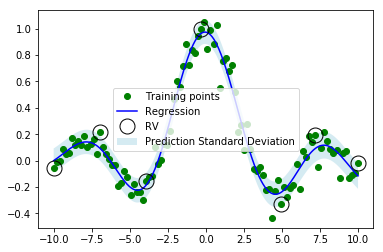

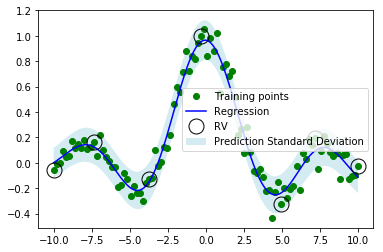

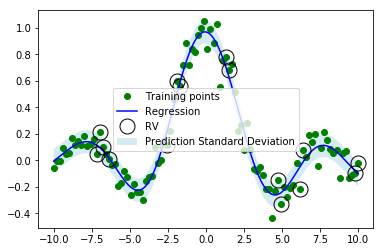

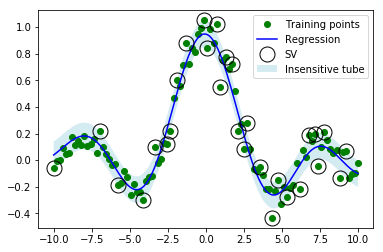

In [48]:
# Train with tuned hyperparameters
trainAndTest(X_tr, Y_tr, X_tst, Y_tst, C = C_values[svm_params[0]], eps = epsilon_values[svm_params[1]], \
            sigma_SV = sigma[svm_params[2]], sigma_EM = sigma[rvm_EM_params[0]], \
            sigma_DD = sigma[rvm_DD_params[0]], sigma_BL = sigma[rvm_BL_params[0]])

In [53]:
X_tr, Y_tr, X_tst, Y_tst = genData("Sinc2", norm = False)

division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
Execution time of SVM 5-fold CV: 313.755271
Execution time of EM RVM 5-fold CV: 313.7309379999988
Execution time of DD RVM 5-fold CV: 300.351369
Execution time of SSBL RVM 5-fold CV: 60.394029000000955
(1, 0, 4)
(4,)
(4,)
(3,)
Friedman 2
EM error: 0.0527159932808
DD error: 0.0545004525482
BL error: 0.0532827207858
SVM error: 0.0560873422712
EM Relevant vectors: 5.0
DD Relevant vectors: 5.0
BL Relevant vectors: 17.0
SVM support vectors: 11.0
EM training time: 17.443123000000924
DD train

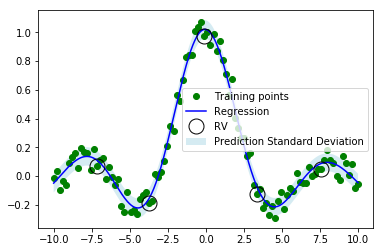

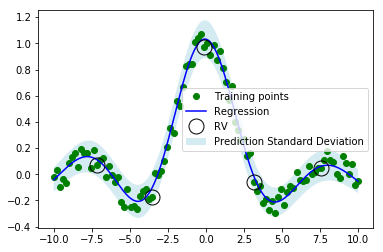

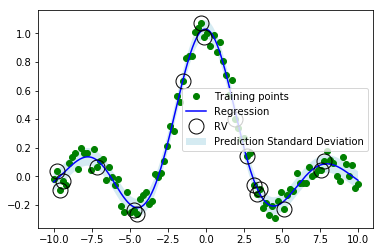

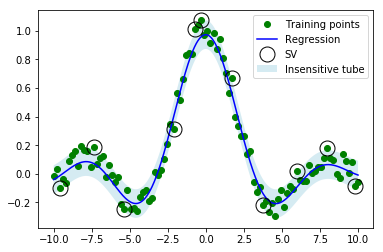

In [59]:
C_values = [1, 3, 5, 10, 20, 40]
epsilon_values = [0.1, 0.15, 0.4]
sigma = [0.5, 1, 2, 3.5, 5]
folds = 5

# Tune the hyperparameters for SVM with a grid search and a 5-fold cross validation
params = [C_values, epsilon_values, sigma]
start = time.clock()
svm_params = tune_hyperparams(X_tr, Y_tr, params, "svm_reg", svmType = "C", kerType = "radial", N = folds)
print("Execution time of SVM 5-fold CV: " + str(time.clock() - start))

# Tune the hyperparameter sigma of the radial kernel for each RVM type
params = [sigma]
start = time.clock()
rvm_EM_params = tune_hyperparams(X_tr, Y_tr, params, "rvm_reg", rvmType = "EM", kerType = "radial", N = folds)
print("Execution time of EM RVM 5-fold CV: " + str(time.clock() - start))
start = time.clock()
rvm_DD_params = tune_hyperparams(X_tr, Y_tr, params, "rvm_reg", rvmType = "DD", kerType = "radial", N = folds)
print("Execution time of DD RVM 5-fold CV: " + str(time.clock() - start))
start = time.clock()
rvm_BL_params = tune_hyperparams(X_tr, Y_tr, params, "rvm_reg", rvmType = "SSBL", kerType = "radial", N = folds)
print("Execution time of SSBL RVM 5-fold CV: " + str(time.clock() - start))

#Print chosen parameter indexes
print(svm_params)
print(rvm_EM_params)
print(rvm_DD_params)
print(rvm_BL_params)

In [ ]:
# Train with tuned hyperparameters
trainAndTest(X_tr, Y_tr, X_tst, Y_tst, C = C_values[svm_params[0]], eps = epsilon_values[svm_params[1]], \
            sigma_SV = sigma[svm_params[2]], sigma_EM = sigma[rvm_EM_params[0]], \
            sigma_DD = sigma[rvm_DD_params[0]], sigma_BL = sigma[rvm_BL_params[0]])

In [66]:
X_tr, Y_tr, X_tst, Y_tst = genData("F1", norm = False)

1.0
1.0


In [26]:
C_values = [1, 3, 10, 20, 40, 100]
epsilon_values = [0.1, 0.5, 4, 8]
sigma = [0.1, 1, 2, 3.5, 5]
folds = 5

# Tune the hyperparameters for SVM with a grid search and a 5-fold cross validation
params = [C_values, epsilon_values, sigma]
start = time.clock()
svm_params = tune_hyperparams(X_tr, Y_tr, params, "svm_reg", svmType = "C", kerType = "radial", N = folds)
print("Execution time of SVM 5-fold CV: " + str(time.clock() - start))

# Tune the hyperparameter sigma of the radial kernel for each RVM type
params = [sigma]
start = time.clock()
rvm_EM_params = tune_hyperparams(X_tr, Y_tr, params, "rvm_reg", rvmType = "EM", kerType = "radial", N = folds)
print("Execution time of EM RVM 5-fold CV: " + str(time.clock() - start))
start = time.clock()
rvm_DD_params = tune_hyperparams(X_tr, Y_tr, params, "rvm_reg", rvmType = "DD", kerType = "radial", N = folds)
print("Execution time of DD RVM 5-fold CV: " + str(time.clock() - start))
start = time.clock()
rvm_BL_params = tune_hyperparams(X_tr, Y_tr, params, "rvm_reg", rvmType = "SSBL", kerType = "radial", N = folds)
print("Execution time of SSBL RVM 5-fold CV: " + str(time.clock() - start))

#Print chosen parameter indexes
print(svm_params)
print(rvm_EM_params)
print(rvm_DD_params)
print(rvm_BL_params)

Execution time of SVM 5-fold CV: 295.4025439999996
Execution time of EM RVM 5-fold CV: 393.5480520000001
Execution time of DD RVM 5-fold CV: 396.37985800000024
Execution time of SSBL RVM 5-fold CV: 24.265674000000217
(0, 0, 0)
(0,)
(0,)
(0,)


In [64]:
# Train with tuned hyperparameters
trainAndTest(X_tr, Y_tr, X_tst, Y_tst, C = C_values[svm_params[0]], eps = epsilon_values[svm_params[1]], \
            sigma_SV = sigma[svm_params[2]], sigma_EM = sigma[rvm_EM_params[0]], \
            sigma_DD = sigma[rvm_DD_params[0]], sigma_BL = sigma[rvm_BL_params[0]])

Friedman 2
EM error: 0.0073776696515
DD error: 0.00850010542533
BL error: 0.00796652262853
SVM error: 0.00703264643236
EM Relevant vectors: 5.0
DD Relevant vectors: 2.0
BL Relevant vectors: 103.0
SVM support vectors: 58.0
EM training time: 143.35926699999982
DD training time: 135.76467299999968
BL training time: 11.197143999999753
SVM training time: 80.56991899999957
